In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import sympy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot

from SimPEG.EM import FDEM
from SimPEG import Utils, Maps

import casingSimulations

from pymatsolver import Pardiso

%matplotlib inline

In [2]:
from SimPEG.EM import Analytics

In [3]:
simDir = 'validate_HED_analytic'

# Validate against HED

Use geometry from the [well_A example](../casing3D/WellA.ipynb) to generate a mesh suitable for capturing casing parameters. Here, the well is a bit shorter to speed up calc and get away with a slightly shorter mesh 

## Example casing model

Here we ignore all conductivity and permeability structures and only use the geometry to generate the mesh

In [4]:
# Casing parameters
casing_d = 20e-2 # first pass, lets use a 20cm casing diameter
casing_t = 1e-2 # 1cm casing thickness
casing_l = 1500 # use a well that is 1.5km long

freqs = np.r_[1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.2, 0.5, 1.]  # 1e-6

sigma_back = 1e-1

src_a = np.r_[500-5, np.pi, 1.] # put the dipole at the surface, 500m from the "well"
src_b = np.r_[500+5, np.pi, 1.]

## Whole space Model

In [5]:
# set up the casing properties
cp = casingSimulations.CasingParameters(
    sigma_back = sigma_back,
    sigma_layer = sigma_back,
    sigma_inside = sigma_back,
    sigma_casing = sigma_back, 
    sigma_air = sigma_back,
    mur_casing = 1., 
    casing_d = casing_d,
    casing_l = casing_l,
    casing_t = casing_t,
    freqs = freqs, 
    src_a = src_a,
    src_b = src_b
)

In [6]:
cp.serialize()

{u'__class__': 'CasingParameters',
 'casing_d': 0.2,
 'casing_l': 1500.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'freqs': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.2, 0.5, 1.0],
 'layer_z': [-1000.0, -900.0],
 'mur_casing': 1.0,
 'sigma_air': 0.1,
 'sigma_back': 0.1,
 'sigma_casing': 0.1,
 'sigma_inside': 0.1,
 'sigma_layer': 0.1,
 'src_a': [495.0, 3.141592653589793, 1.0],
 'src_b': [505.0, 3.141592653589793, 1.0],
 'version': u'0.0.1'}

In [7]:
cp.save(directory=simDir)

## Construct a mesh

In [85]:
npadx, npadz = 19, 24
dx2 = casing_l  # go out as far as the casing is deep 
csx2 = 25.
csz = 5.
pfx2 = 1.4
pfz = 1.4

ncy = 1
nstretchy = 5
stretchfact = 1.5
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

cylMeshGen = casingSimulations.CasingMeshGenerator(
    cp=cp, 
    npadx=npadx, 
    npadz=npadz, 
    domain_x2=dx2, 
    hy=hy, 
    csx2=csx2, 
    csz=csz,
    pfx2=pfx2, 
    pfz=pfz
)

In [86]:
mesh = cylMeshGen.mesh

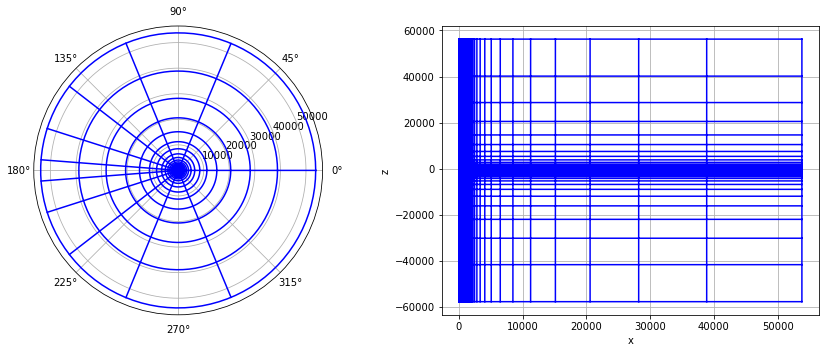

In [87]:
mesh.plotGrid()

In [88]:
print cp.skin_depth()

[ 159154.9430919    91888.14923697   50329.21210449   29057.58415663
   15915.49430919    9188.8149237     5032.92121045    3558.81271709
    2250.79079039    1591.54943092]


In [89]:
cylMeshGen.save(directory=simDir)

## Construct a source

In [90]:
src = casingSimulations.sources.HorizontalElectricDipole(cp=cp, mesh=mesh)

In [91]:
src.surface_wire.nonzero()

(array([572686]),)

(0.0, 600.0)

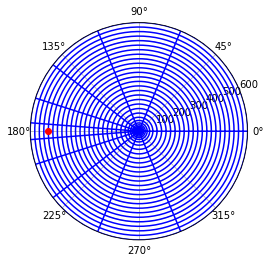

In [95]:
ax = plt.subplot(111, projection='polar')
mesh.plotGrid(ax=ax, slice='z')
ax.plot(mesh.gridFx[src.surface_wire,1], mesh.gridFx[src.surface_wire,0], 'ro')
ax.set_rlim([0., 600.])

In [96]:
physprops = casingSimulations.PhysicalProperties(mesh, cp)

[(-2000.0, 0), (-2000.0, 0)]

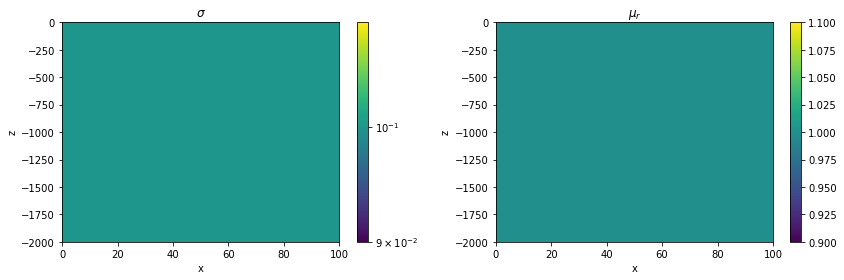

In [97]:
xlim = [0., 100.]
ylim = [-2000., 0]

ax = physprops.plot()
[a.set_xlim(xlim) for a in ax]
[a.set_ylim(ylim) for a in ax]

In [98]:
set(physprops.sigma)

{0.10000000000000001}

In [99]:
set(physprops.mur)

{1.0}

In [8]:
casingSimulations.utils.writeSimulationPy(
    directory=simDir, 
    srcType='HorizontalElectricDipole',
)

wrote validate_HED_analytic/simulation.py


# Load results

In [9]:
meshGen=casingSimulations.load_properties('/'.join([simDir, 'MeshParameters.json']))
cp = casingSimulations.load_properties('/'.join([simDir, 'CasingParameters.json']))
hfield = np.load('/'.join([simDir, 'fields.npy']))

In [11]:
simulation = casingSimulations.run.SimulationFDEM(cp=cp, meshGenerator=meshGen, srcType='HorizontalElectricDipole')
simulation.prob.model = simulation.physprops.model

In [12]:
fields = simulation.prob.fieldsPair(meshGen.mesh, simulation.survey)
fields[:,'hSolution'] = hfield

In [13]:
srcList = simulation.survey.srcList
mesh = meshGen.mesh
mesh2D = discretize.CylMesh([mesh.hx, 1., mesh.hz], x0=mesh.x0) # for plotting

In [62]:
# look at a slice along the plane of the source
srcind = 3
theta_ind = 1

jcyl = fields[srcList[srcind],'j']
jplt = casingSimulations.face3DthetaSlice(mesh, jcyl, theta_ind=theta_ind)
ecyl = fields[srcList[srcind],'e']
eplt = casingSimulations.face3DthetaSlice(mesh, ecyl, theta_ind=theta_ind)
bcyl = fields[srcList[srcind], 'b']
bplt = casingSimulations.edge3DthetaSlice(mesh, bcyl, theta_ind=theta_ind)

print('freq: {} Hz'.format(srcList[srcind].freq))

freq: 0.003 Hz


In [63]:
src_a = simulation.src.src_a
src_b = simulation.src.src_b
print(src_a, src_b)

(array([ 495.        ,    3.14159265,    1.        ]), array([ 505.        ,    3.14159265,    1.        ]))


In [64]:
# compare against analytic 

length = meshGen.csx2
loc = np.r_[-(src_b[0] + src_a[0])/2., 0., src_b[2]]

eana_x_Fx, eana_y_Fx, _ = Analytics.E_from_ElectricDipoleWholeSpace(
    mesh.cartesianGrid('Fx'), 
    loc, sig=sigma_back, f=np.r_[srcList[srcind].freq], current=1., 
    length=length, orientation='X'
)

eana_x_Fy, eana_y_Fy, _ = Analytics.E_from_ElectricDipoleWholeSpace(
    mesh.cartesianGrid('Fy'),
    loc, sig=sigma_back, f=np.r_[srcList[srcind].freq], current=1., 
    length=length, orientation='X'
)

_, _, eana_z = Analytics.E_from_ElectricDipoleWholeSpace(
    mesh.cartesianGrid('Fz'), loc, sig=sigma_back, f=np.r_[srcList[srcind].freq], current=1., 
    length=length, orientation='X'
)
# eana = utils.mkvc(np.hstack([eana_x, eana_z]),2)
# jana = sigma_back * eana

In [65]:
# Looking at the theta = 90 degree slice
eana_plt_x = utils.mkvc(eana_y_Fx.reshape(mesh.vnFx, order='F')[:, theta_ind, :], 2)
eana_plt_z = utils.mkvc(eana_z.reshape(mesh.vnFz, order='F')[:, theta_ind, :], 2)
eanaplt = np.vstack([eana_plt_x, eana_plt_z])

janaplt = sigma_back*eanaplt

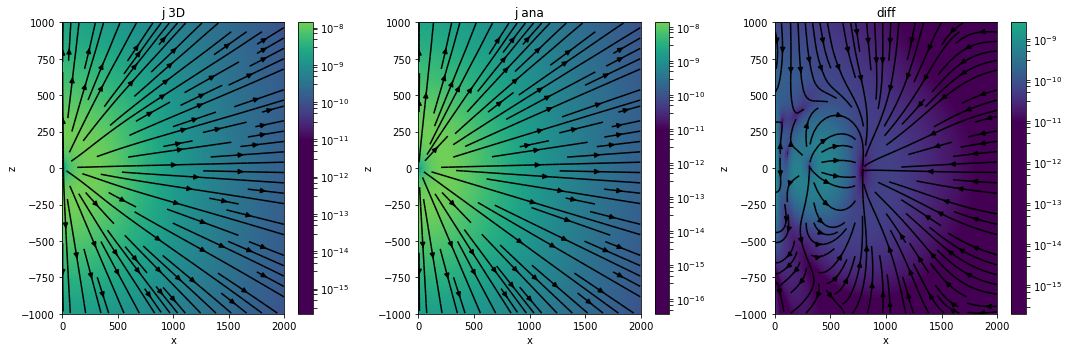

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

pltargs = {
    'mirror':False,
    'range_x':np.r_[0., 2000.],
    'range_y':np.r_[-1000., 1000.],
    'sample_grid':np.r_[10., 10.],
    'clim':np.r_[1e-11, 1e-7]
}


casingSimulations.plotFace2D(
    mesh2D, jplt, ax=ax[0], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, janaplt, ax=ax[1], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, jplt-janaplt, ax=ax[2], **pltargs
)

ax[0].set_title('j 3D')
ax[1].set_title('j ana')
ax[2].set_title('diff')


plt.tight_layout()

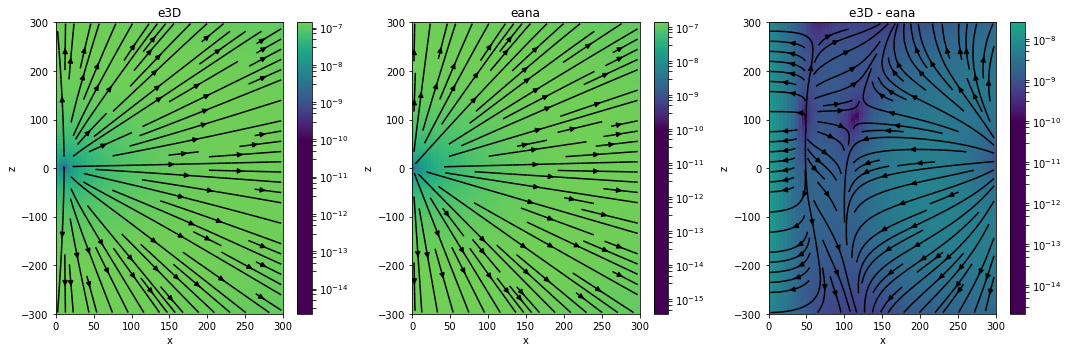

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

pltargs = {
    'mirror':False,
    'range_x':np.r_[0., 300.],
    'range_y':np.r_[-300., 300.],
    'sample_grid':np.r_[5.,5.],
    'clim':np.r_[1e-10, 1e-6]
}

casingSimulations.plotFace2D(
    mesh2D, eplt, ax=ax[0], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, eanaplt, ax=ax[1], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, eplt-eanaplt, ax=ax[2], **pltargs
)

ax[0].set_title('e3D')
ax[1].set_title('eana')
ax[2].set_title('e3D - eana')

plt.tight_layout()

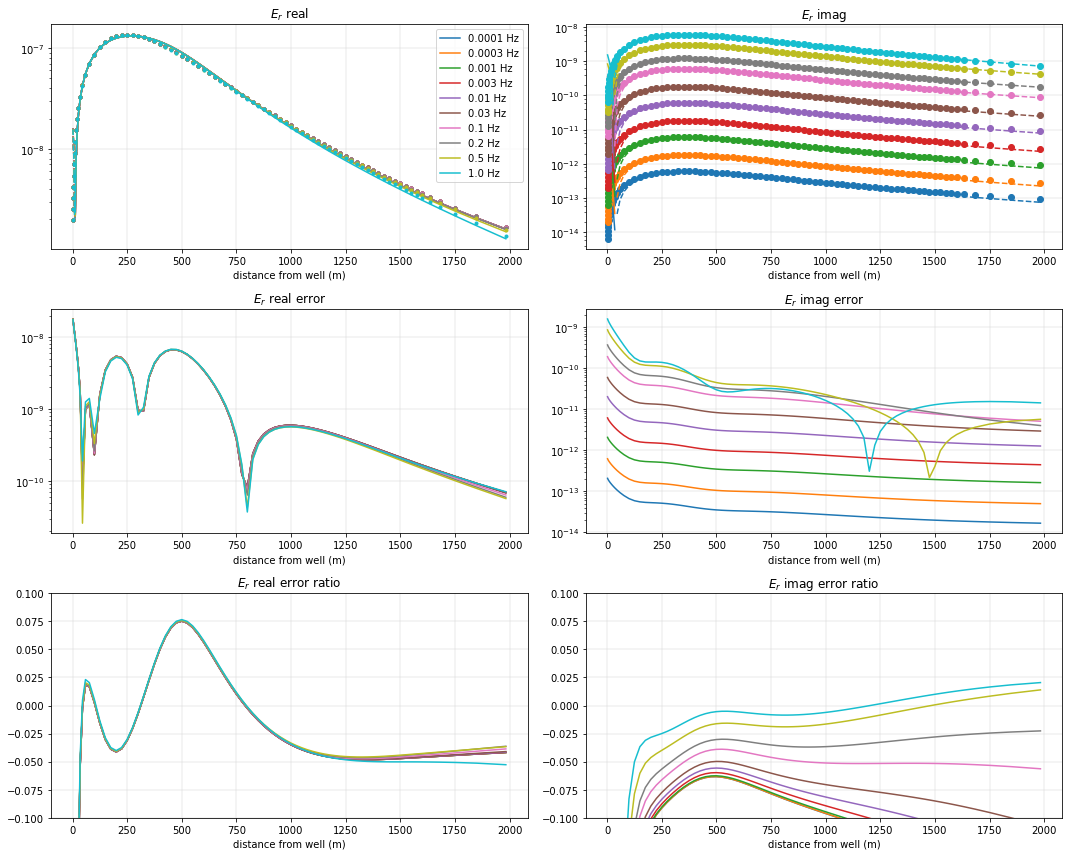

In [78]:
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
ax = utils.mkvc(ax)

for i, src in enumerate(srcList):
    ecyl = fields[src, 'e']
    eplt = casingSimulations.face3DthetaSlice(mesh, ecyl, theta_ind=theta_ind)
    
    e3D_x = utils.mkvc(eplt[:mesh2D.vnF[0]].reshape([mesh2D.vnFx[0], mesh2D.vnFx[2]], order='F'))
    

    xind = ((mesh2D.gridFx[:,0] > 2.) & (mesh2D.gridFx[:,0] < 2000.)) 
    zind = ((mesh2D.gridFx[:,2] > 0.) & (mesh2D.gridFx[:,2] < mesh2D.hz.min()))
    pltind = xind & zind
    
    _, eana_y_Fx, _ = Analytics.E_from_ElectricDipoleWholeSpace(
        mesh.cartesianGrid('Fx'), 
        loc, sig=sigma_back, f=np.r_[src.freq], current=1., 
        length=length, orientation='X'
    )
    
    eana_plt_x = utils.mkvc(eana_y_Fx.reshape(mesh.vnFx, order='F')[:, theta_ind, :])
    eana_x = eana_plt_x[pltind]
    
    ex = e3D_x[pltind]
    x = mesh2D.gridFx[pltind, 0]
    
    label='{} Hz'.format(src.freq)
    
    ax[0].semilogy(x, -ex.real, '--', color='C{}'.format(i))
    ax[3].semilogy(x, -ex.imag, '--', color='C{}'.format(i))
    
    ax[0].semilogy(x, -eana_x.real, 'o', color='C{}'.format(i))
    ax[3].semilogy(x, -eana_x.imag, 'o', color='C{}'.format(i))
    
    ax[0].semilogy(x, ex.real, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))
    ax[3].semilogy(x, ex.imag, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))
    
    ax[0].semilogy(x, eana_x.real, '.', color='C{}'.format(i))
    ax[3].semilogy(x, eana_x.imag, '.', color='C{}'.format(i))
    
    ax[1].semilogy(x, np.abs(ex.real - eana_x.real), '-', color='C{}'.format(i))
    ax[4].semilogy(x, np.abs(ex.imag - eana_x.imag), '-', color='C{}'.format(i))
    
    ax[2].plot(x, (ex.real - eana_x.real)/eana_x.real, '-', color='C{}'.format(i))
    ax[5].plot(x, (ex.imag - eana_x.imag)/eana_x.imag, '-', color='C{}'.format(i))
    
#     ax[1].loglog(x, ex.real, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))
#     ax[3].loglog(x, ex.imag, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))

ax[0].legend()
ax[1].legend()

ax[0].set_title('$E_r$ real')
ax[3].set_title('$E_r$ imag')

ax[1].set_title('$E_r$ real error')
ax[4].set_title('$E_r$ imag error')

ax[2].set_title('$E_r$ real error ratio')
ax[5].set_title('$E_r$ imag error ratio')

[a.grid('both', linestyle='-', linewidth=0.4, color=[0.8, 0.8, 0.8]) for a in ax]
[a.set_xlabel('distance from well (m)') for a in ax]

[a.set_ylim(0.1*np.r_[-1., 1]) for a in [ax[2], ax[5]]]

plt.tight_layout()